In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import Normalize
%matplotlib inline

# 0. Functions

In [3]:
def getstats(db):
    stat = {}
    for unc in uncs:
        stat['unc' + str(unc)] = stats.describe(db['LLunc'+str(unc)])
        print('{}% Unc Stats: {} \n'.format(unc*100, stat['unc'+str(unc)]))
    return stat

In [13]:
def plotme(g_or_b, XYZ, title, zname, vmin, vmax):
    fig = plt.figure(figsize=(10, 8))
    #cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
    ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
    
    x = XYZ['Burnup']
    y = XYZ['CoolingTime']
    triang_unref = tri.Triangulation(x, y)
    z_unref = XYZ[zname]
    
    refiner = tri.UniformTriRefiner(triang_unref)
    triang, z = refiner.refine_field(z_unref)
    
    surf = ax.tripcolor(triang, z, norm=norm, cmap=cm.viridis, shading='gouraud')
    #surf = ax.tricontourf(triang, z, norm=norm, cmap=cm.viridis)
    if g_or_b == 'g':
        xtr = pred_g['Burnup']
        ytr = pred_g['CoolingTime']
        ax.set_xlim(24000, 29000)
        ax.set_ylim(1750, 4250)
    else:
        xtr = pred_b['Burnup']
        ytr = pred_b['CoolingTime']
        ax.set_xlim(7000, 25000)
        ax.set_ylim(0, 400)
    xpr = XYZ['Burnup'].iloc[XYZ[zname].idxmax()]
    ypr = XYZ['CoolingTime'].iloc[XYZ[zname].idxmax()]
    plt.plot([xpr], [ypr], marker='o', markersize=4, color="white")
    ax.annotate('Best Prediction', (xpr, ypr), weight='bold', xytext=(0, 5), textcoords='offset points')
    plt.plot([xtr], [ytr], marker='s', markersize=4, color="white")
    ax.annotate('Ground Truth', (xtr, ytr), weight='bold', xytext=(5, 2), textcoords='offset points')
    ax.tick_params(labelsize=14)
    
    cbar = fig.colorbar(surf)
    cbar.ax.set_ylabel('Likelihood', size=20, labelpad=15)
    cbar.ax.tick_params(labelsize=14)
    
    plt.tight_layout()
    plt.show()
    plt.clf()
    #fig.savefig('../plots/llsurf_***.png', bbox_inches='tight', transparent=True)

# 1. Retreive LL calc results

## (a) Test samples for LL calcs

In [5]:
g = pd.read_pickle('../mll_calc/htc_files/train_good.pkl')
g

,AvgPowerDensity,Burnup,CoolingTime,Enrichment,ModDensity,OrigenReactor,ReactorType,UiWeight,am241,am242m,...,sm147,sm149,sm150,sm151,sm152,total,u234,u235,u236,u238
9.888e+03,10.0,69769.38,2910.6605,5.11,0.74,atrium10x10-9,bwr,1,661.6,2.581,...,431.2,1.866,498.8,12.33,159.8,1000000.0,214.1,3630.0,7110.0,904500.0


In [6]:
b = pd.read_pickle('../mll_calc/htc_files/train_bad.pkl')
b

,AvgPowerDensity,Burnup,CoolingTime,Enrichment,ModDensity,OrigenReactor,ReactorType,UiWeight,am241,am242m,...,sm147,sm149,sm150,sm151,sm152,total,u234,u235,u236,u238
1.832e+03,25.0,10887.95,1396.689271,4.52,0.71,w17x17,pwr,1,40.34,0.03287,...,92.94,3.618,85.34,10.25,40.01,1000000.0,312.0,33500.0,2356.0,948000.0


## (b) LL calcs for uncertainty = 5%, 10%, 15%, 20%

In [7]:
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
nonlbls = ['AvgPowerDensity', 'ModDensity', 'UiWeight']

In [8]:
results = '~/sims_n_results/simupdates_aug2020/full_ll/'

uncs = [0.05, 0.1, 0.15, 0.2]
job_dirs = ['Job' + str(i) + '_unc' + str(unc) for i, unc in enumerate(uncs)]
ll = {}
for i, unc_job in enumerate(job_dirs):
    csv = unc_job + '/' + unc_job + '.csv'
    if i == 0:
        ll['good'] = pd.read_csv(results + 'train_good/' + csv).drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).rename(columns={'LL':'LLunc'+str(uncs[i])})
        ll['bad'] = pd.read_csv(results + 'train_bad/' + csv).drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).rename(columns={'LL':'LLunc'+str(uncs[i])})
    else:
        ll['good']['LLunc'+str(uncs[i])] = pd.read_csv(results + 'train_good/' + csv)['LL']
        ll['bad']['LLunc'+str(uncs[i])] = pd.read_csv(results + 'train_bad/' + csv)['LL']

In [9]:
pred_g = pd.read_pickle('pred_good.pkl')
pred_b = pd.read_pickle('pred_bad.pkl')

#bidx = 283935
#gidx = 178095
pred_g

,sim_idx,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,AvgPowerDensity,ModDensity,UiWeight,pred_idx,...,CDF_LLUnc_0.5,CDF_LogLL_0.1,CDF_LLUnc_0.1,CDF_LogLL_0.01,CDF_LLUnc_0.01,ReactorType_Score,CoolingTime_Error,Enrichment_Error,Burnup_Error,OrigenReactor_Score
5824,178095,bwr,1053.708101,5.11,1030.7,atrium10x10-9,20.0,0.74,1,179775,...,1380.805811,-1.171839e+07,98.882337,-7.710935e+08,79.660394,True,0.0,0.0,0.0,True


In [10]:
pred_b

,sim_idx,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,AvgPowerDensity,ModDensity,UiWeight,pred_idx,...,CDF_LLUnc_0.5,CDF_LogLL_0.1,CDF_LLUnc_0.1,CDF_LogLL_0.01,CDF_LLUnc_0.01,ReactorType_Score,CoolingTime_Error,Enrichment_Error,Burnup_Error,OrigenReactor_Score
9275,283935,pwr,1270.348072,4.52,20178.59,w17x17,25.0,0.71,1,173957,...,33969.690711,-2.828594e+09,371.005296,-5.453713e+16,54.95242,False,27.72854,0.59,1668.54,False


# 2. Likelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [11]:
stat_good = getstats(ll['good'])

5.0% Unc Stats: DescribeResult(nobs=367200, minmax=(0.0, 2.2603704972648677e-48), mean=7.226822502311873e-54, variance=1.433531968229822e-101, skewness=582.5106620478169, kurtosis=346251.66208189185) 

10.0% Unc Stats: DescribeResult(nobs=367200, minmax=(0.0, 4.2102681421951726e-57), mean=2.332064833245463e-62, variance=6.637661052173785e-119, skewness=457.97460046546774, kurtosis=219708.16966770255) 

15.0% Unc Stats: DescribeResult(nobs=367200, minmax=(0.0, 3.293542282664854e-62), mean=5.922140421550941e-67, variance=7.126706926994546e-129, skewness=260.9930885588829, kurtosis=86503.03873433675) 

20.0% Unc Stats: DescribeResult(nobs=367200, minmax=(0.0, 7.842235532021472e-66), mean=3.880678220951111e-70, variance=1.1710973002597834e-135, skewness=127.08030370180607, kurtosis=19307.73164769534) 



In [12]:
stat_bad = getstats(ll['bad'])

5.0% Unc Stats: DescribeResult(nobs=367200, minmax=(0.0, 2.943499876775873e-23), mean=9.10462148294986e-29, variance=2.3903045915534485e-51, skewness=595.1369559628, kurtosis=357855.6101249293) 

10.0% Unc Stats: DescribeResult(nobs=367200, minmax=(0.0, 5.4826957672385e-32), mean=2.9801225728712043e-37, variance=1.206563502171907e-68, skewness=417.67767129778053, kurtosis=188630.11538043703) 

15.0% Unc Stats: DescribeResult(nobs=367200, minmax=(0.0, 4.288916934153446e-37), mean=3.2938316912359864e-42, variance=1.0444374532525907e-78, skewness=358.0121446509633, kurtosis=132440.95247053384) 

20.0% Unc Stats: DescribeResult(nobs=367200, minmax=(0.0, 1.0212316675555892e-40), mean=1.399961490141919e-45, variance=7.709601785205147e-86, skewness=308.5982998472981, kurtosis=102717.02872348868) 



/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


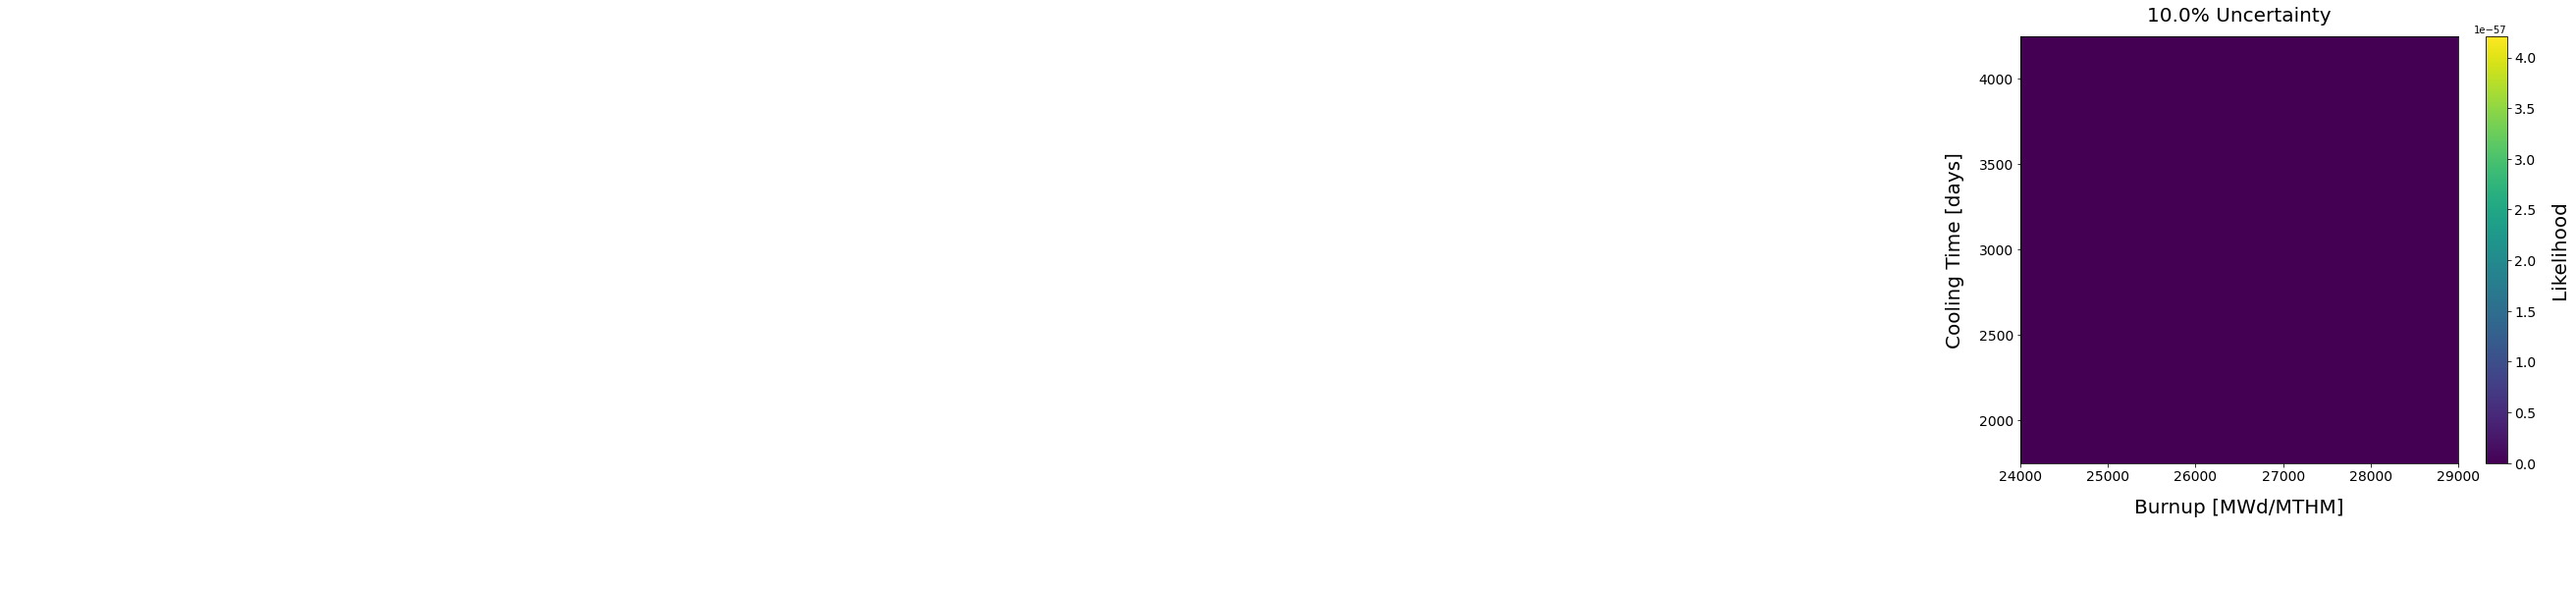

In [ ]:
for i, unc in enumerate(uncs[1:3]):
    zname = 'LLunc'+str(unc)
    title = str(unc*100) + '% Uncertainty'
    vmin = 0
    vmax = stat_good['unc' + str(unc)].minmax[1]
    plotme('g', ll['good'][['Burnup', 'CoolingTime', zname]], title, zname, vmin, vmax)

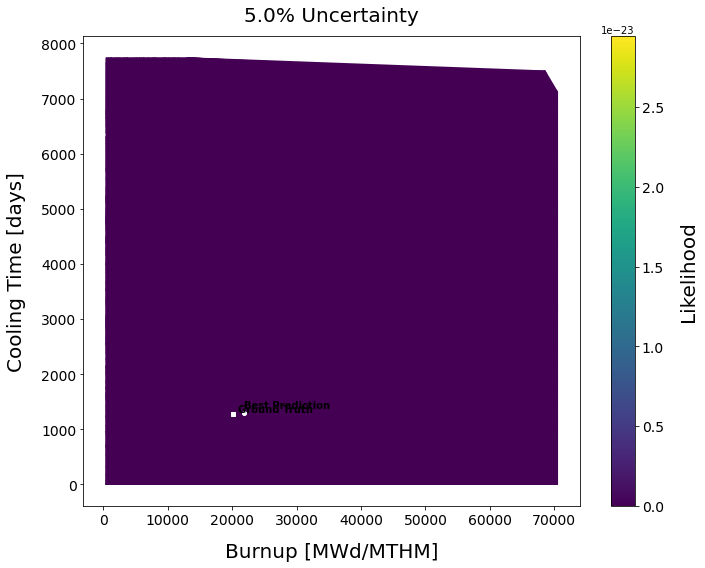

<Figure size 432x288 with 0 Axes>

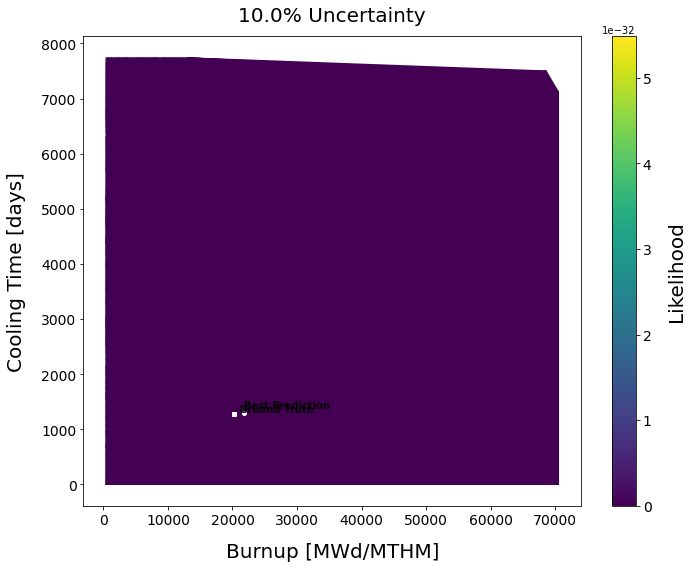

<Figure size 432x288 with 0 Axes>

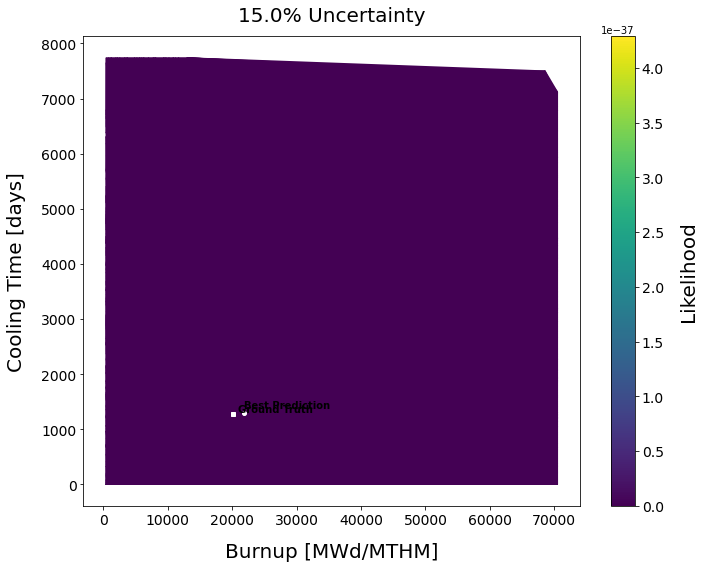

<Figure size 432x288 with 0 Axes>

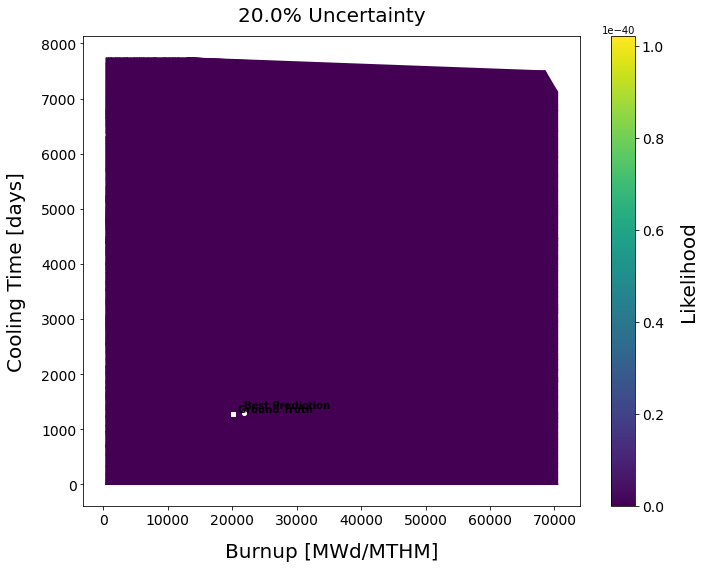

<Figure size 432x288 with 0 Axes>

In [30]:
for i, unc in enumerate(uncs[0:4]):
    zname = 'LLunc'+str(unc)
    title = str(unc*100) + '% Uncertainty'
    vmin = 0#stat_bad['unc' + str(unc)].mean
    vmax = stat_bad['unc' + str(unc)].minmax[1]
    plotme('b', ll['bad'][['Burnup', 'CoolingTime', zname]], title, zname, vmin, vmax)

# 4 Oct 2020 end of update

## _______________________________

# 3. Get LL Pred Results

In [102]:
ll1 = 'LogLikelihood_0.05'
ll2 = 'LogLikelihood_0.1'
ll3 = 'LogLikelihood_0.15'
ll4 = 'LogLikelihood_0.2'
lu1 = 'LLUncertainty_0.05'
lu2 = 'LLUncertainty_0.1'
lu3 = 'LLUncertainty_0.15'
lu4 = 'LLUncertainty_0.2'
lls = [ll1, ll2, ll3, ll4]
lus = [lu1, lu2, lu3, lu4]
uncs = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [103]:
fullXY.head()

,Unnamed: 0,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
0,1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,...,2.507794e+10,0.0,-6.276547e+10,1.253897e+10,0.0,-2.789577e+10,8.359314e+09,0.0,-1.569137e+10,6.269485e+09
1,2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,...,2.507794e+10,0.0,-6.276537e+10,1.253897e+10,0.0,-2.789572e+10,8.359314e+09,0.0,-1.569134e+10,6.269485e+09
2,3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,...,2.507794e+10,0.0,-6.276530e+10,1.253897e+10,0.0,-2.789569e+10,8.359314e+09,0.0,-1.569132e+10,6.269485e+09
3,4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,...,2.507794e+10,0.0,-6.276469e+10,1.253897e+10,0.0,-2.789542e+10,8.359314e+09,0.0,-1.569117e+10,6.269485e+09
4,5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,...,2.507794e+10,0.0,-6.276476e+10,1.253897e+10,0.0,-2.789545e+10,8.359314e+09,0.0,-1.569119e+10,6.269486e+09


## Reactor Prediction

In [104]:
data = {}
idx = {}
for ll, lu in zip(lls, lus):
    max_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].max()
    idx_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].idxmax()
    unc_pwr = float(fullXY[lu].loc[fullXY.index == idx_pwr])
    max_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].max()
    idx_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].idxmax()
    unc_bwr = float(fullXY[lu].loc[fullXY.index == idx_bwr])
    max_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].max()
    idx_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].idxmax()
    unc_phwr = float(fullXY[lu].loc[fullXY.index == idx_phwr])
    data[ll] = [max_pwr, max_bwr, max_phwr]
    data[lu] = [unc_pwr, unc_bwr, unc_phwr]
    idx[ll] = [idx_pwr, idx_bwr, idx_phwr]
rxtr = pd.DataFrame(data, columns=[ll1, lu1, ll2, lu2, ll3, lu3, ll4, lu4], index=['pwr', 'bwr', 'phwr'])
rxtr

,LogLikelihood_0.05,LLUncertainty_0.05,LogLikelihood_0.1,LLUncertainty_0.1,LogLikelihood_0.15,LLUncertainty_0.15,LogLikelihood_0.2,LLUncertainty_0.2
pwr,18.967565,3.254686,10.520009,1.627343,5.024011,1.508366,0.943795,1.131275
bwr,2.344970,8.902489,6.566396,4.451245,3.208129,3.008143,-0.083764,2.718742
phwr,-451595.105989,37524.646638,-112875.317334,18762.323319,-50153.587113,12508.215546,-28203.168076,9381.161659


In [105]:
idx

{'LogLikelihood_0.05': [2831, 21324, 24672],
 'LogLikelihood_0.1': [2831, 21324, 24672],
 'LogLikelihood_0.15': [3893, 21315, 24672],
 'LogLikelihood_0.2': [3893, 14034, 24672]}

In [106]:
for ll in lls:
    print(ll)
    for i, index in enumerate(idx[ll]):
        print(fullXY.loc[fullXY.index == idx[ll][i], ['ReactorType', 'Burnup', 'CoolingTime']])

LogLikelihood_0.05
     ReactorType    Burnup  CoolingTime
2831         pwr  40412.05   392.313045
      ReactorType    Burnup  CoolingTime
21324         bwr  37521.68    34.458875
      ReactorType    Burnup  CoolingTime
24672        phwr  13678.58     5.662128
LogLikelihood_0.1
     ReactorType    Burnup  CoolingTime
2831         pwr  40412.05   392.313045
      ReactorType    Burnup  CoolingTime
21324         bwr  37521.68    34.458875
      ReactorType    Burnup  CoolingTime
24672        phwr  13678.58     5.662128
LogLikelihood_0.15
     ReactorType    Burnup  CoolingTime
3893         pwr  39013.38   343.237299
      ReactorType    Burnup  CoolingTime
21315         bwr  37361.88    34.458875
      ReactorType    Burnup  CoolingTime
24672        phwr  13678.58     5.662128
LogLikelihood_0.2
     ReactorType    Burnup  CoolingTime
3893         pwr  39013.38   343.237299
      ReactorType    Burnup  CoolingTime
14034         bwr  36727.11    37.125682
      ReactorType    Burnup  Coo

In [71]:
max_tot = fullXY[ll1].max()
idx = fullXY[ll1].idxmax()
max_tot, idx

(68.62441895096356, 20912)

In [94]:
sim_idx = 13379
top_answer = fullXY.loc[fullXY.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
13379,bwr,2690.358732,2.88,2010.26,ge9x9-2


In [90]:
sim_idx = 10522
top_answer = XY.loc[XY.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
10522,bwr,2421.282899,2.89,2024.53,ge7x7-0


In [82]:
xy = pd.read_csv('likelihood_idx5010_15nucs_opusupdate-aug2019.csv')

In [83]:
xy.head()

,Unnamed: 0,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
0,1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,...,2.507794e+10,0.0,-6.276547e+10,1.253897e+10,0.0,-2.789577e+10,8.359314e+09,0.0,-1.569137e+10,6.269485e+09
1,2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,...,2.507794e+10,0.0,-6.276537e+10,1.253897e+10,0.0,-2.789572e+10,8.359314e+09,0.0,-1.569134e+10,6.269485e+09
2,3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,...,2.507794e+10,0.0,-6.276530e+10,1.253897e+10,0.0,-2.789569e+10,8.359314e+09,0.0,-1.569132e+10,6.269485e+09
3,4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,...,2.507794e+10,0.0,-6.276469e+10,1.253897e+10,0.0,-2.789542e+10,8.359314e+09,0.0,-1.569117e+10,6.269485e+09
4,5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,...,2.507794e+10,0.0,-6.276476e+10,1.253897e+10,0.0,-2.789545e+10,8.359314e+09,0.0,-1.569119e+10,6.269486e+09


In [85]:
max_tot = xy[ll1].max()
idx = xy[ll1].idxmax()
max_tot, idx

(18.967564797385485, 2831)

In [86]:
sim_idx = 2831
top_answer = xy.loc[xy.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
2831,pwr,392.313045,3.07,40412.05,w14x14
